In [1]:
import pandas as pd
import numpy as np

import re
import random

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess, simple_tokenize

import nltk
from pattern.en import lemma

## Load and Clean Data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

df.shape

(7613, 5)

In [3]:
# replace %20 with '' in keyword. used in place of space [] character
df['keyword'] = df['keyword'].apply(lambda s: s.replace('%20', '') if isinstance(s, str) else s)

#### What fraction of keywords and location are missing?

Only 61 rows have keywords missing. We want to see if there is any preliminary difference we can spot between tweets that are identified as disaster vs those that are not.

On the other hand, nearly 33% (or 2533) tweets have location tag missing. This does not vary between disaster vs non-disaster tweets.

In [4]:
print(df.keyword.isna().sum()) #keywords missing
print(df.location.isna().sum()) #location missing

df.groupby('target')['location'].apply(lambda x: x.isna().sum()/len(x))

61
2533


target
0    0.335790
1    0.328646
Name: location, dtype: float64

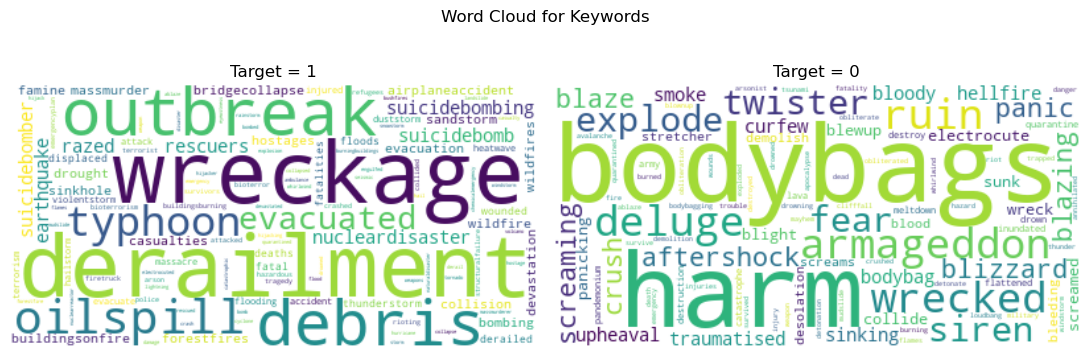

In [5]:
stopwords = set(STOPWORDS)

dict_disaster = df.query('target == 1')['keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Keywords")
plt.tight_layout();
plt.show();

### Cleaning Data - URL, Punctuations, Emoji, etc

In [6]:
def clean_tweet(tweet):

    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    tweet = reg_punc.sub(r'', tweet)

    # remove html
    reg_html = re.compile(r'<.*?>')
    tweet = reg_html.sub(r'', tweet)

    # remove url
    reg_url = re.compile(r'http\S+')
    tweet = reg_url.sub(r'', tweet)

    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    tweet = reg_num.sub(r'', tweet)

    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    tweet = reg_spcl.sub(r'', tweet)

    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = emoji_url.sub(r'', tweet)

    return tweet

df['clean_text'] = df['text'].apply(lambda x: clean_tweet(x))

#### Lemmatization

In [8]:
def lemmatize(tweet, remove_stopword= False):
    if remove_stopword:
        lemmatized_tweet = " ".join([word if word.lower()=="this" else lemma(word) for word in tweet.split() if word not in stopwords])
    else:
        lemmatized_tweet = " ".join([word if word.lower()=="this" else lemma(word) for word in tweet.split()])
    return lemmatized_tweet

df['lemmatized_text'] = df['clean_text'].apply(lambda x: lemmatize(x.lower()))

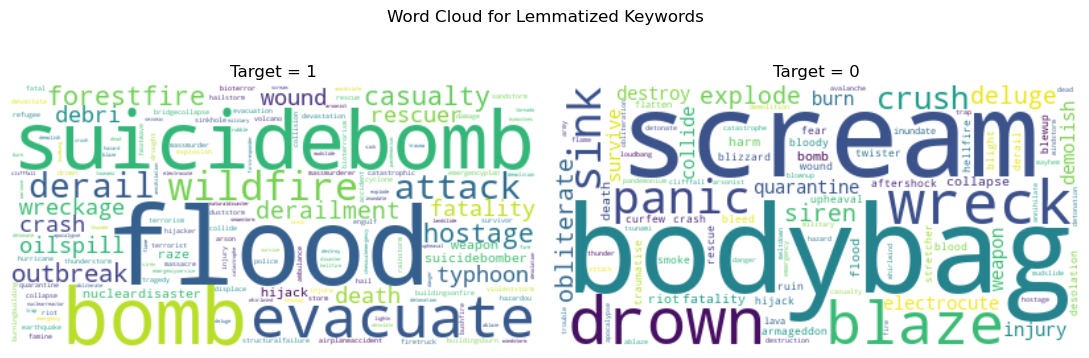

In [9]:
df['lemmatized_keyword'] = df['keyword'].apply(lambda x: lemmatize(x.lower()) if isinstance(x,str) else x)

dict_disaster = df.query('target == 1')['lemmatized_keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['lemmatized_keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Lemmatized Keywords")
plt.tight_layout();
plt.show();

## Build Models

#### Logistic Regression using Keywords
In the statistical inference portion of the code, we observed that there is some difference between the keywords of tweets that represented disaster vs the ones that didn't. Based on this assumption, we can build a simple logistic regression classifier that uses the keywords of the tweets.

**Advantages**
1. Very easy to implement and understand - the coefficients give us a clear intuition of which words increase the probability of the tweet being about an actual disaster vs not.

**Disadvantages**
1. Limited vocabulary. If there is a keyword in the test/validation dataset that we didnt encounter in the training dataset, the model would not know how to handle it.
2. We are not using any of the information in the actual text of the tweets.
3. In any real world application, we would probably have a dataset comprising just the tweet without any keyword attached to it. Limits the application of this model.

             LR_coef
wreckage    2.627808
derailment  2.627808
debri       2.587786
outbreak    2.381983
typhoon     2.339643
...              ...
blaze      -2.069669
panic      -2.170459
ruin       -2.317637
bodybag    -2.346364
aftershock -2.523712

[177 rows x 1 columns]


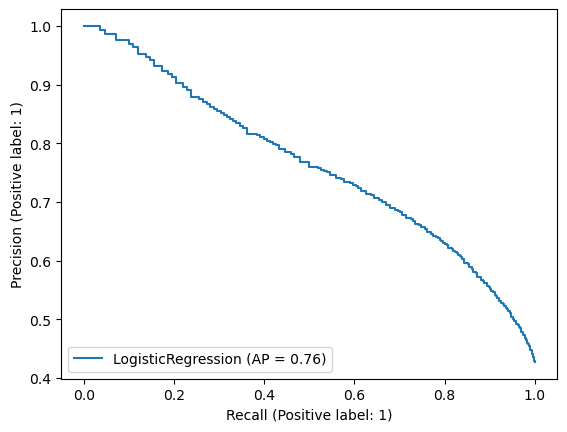

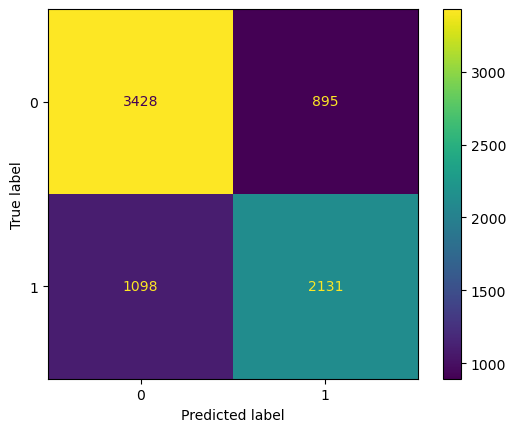

In [25]:
count_vec = CountVectorizer()
X_keyword = count_vec.fit_transform(df['lemmatized_keyword'].dropna())
y_keyword = df.dropna(subset= ['lemmatized_keyword'])['target']

keyword_lreg = LogisticRegression(fit_intercept= False)
keyword_lreg.fit(X_keyword,y_keyword)

print(pd.DataFrame(keyword_lreg.coef_, columns= count_vec.get_feature_names_out(), index= ["LR_coef"])
      .T.sort_values("LR_coef", ascending= False) )

PrecisionRecallDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
ConfusionMatrixDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
# ConfusionMatrixDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
# pd.DataFrame(precision_recall_fscore_support(y_keyword, keyword_lreg.predict(X_keyword)), index= ['precision','recall','f1score','support']).head(2)

In [11]:
cross_val_score(keyword_lreg, X_keyword, y_keyword, cv= 10)

array([0.57275132, 0.1957672 , 0.3192053 , 0.25562914, 0.29933775,
       0.35231788, 0.49536424, 0.44635762, 0.32450331, 0.5192053 ])

#### TF-IDF Vectorization

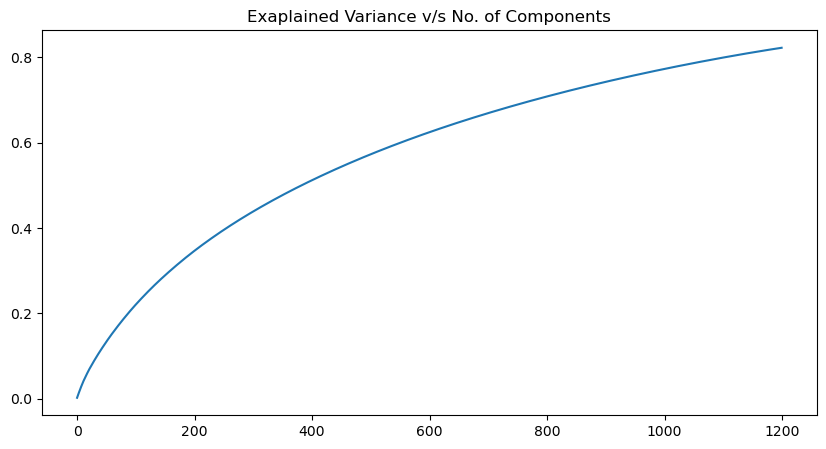

['aa' 'aba' 'aba woman' ... 'zombie apocalypse' 'zone' 'zouma']
(7613, 4849)


In [27]:
corpus = df['lemmatized_text'].tolist()
en_vocab = pd.DataFrame([vv.lower() for vv in nltk.corpus.words.words()], columns= ['words']).drop_duplicates().words.tolist()

vectorizer = TfidfVectorizer(ngram_range= (1,3), stop_words= 'english', strip_accents= 'ascii', min_df= 5e-4, max_df= 0.95)
X = vectorizer.fit_transform(corpus)

# # filter based on english vocabulary
# filtered_vocab = []
# for ff in vectorizer.get_feature_names_out():
#     keep_vocab = True
#     if all([ww in en_vocab for ww in ff.split()]):
#         filtered_vocab.append(ff)

# vectorizer = TfidfVectorizer(ngram_range= (1,2), stop_words= 'english', strip_accents= 'ascii', min_df= 5e-4, max_df= 0.95, vocabulary= filtered_vocab)
# X = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components= 1200)
X_pca = svd.fit_transform(X)

plt.figure(figsize= (10,5))
plt.plot(pd.DataFrame(svd.explained_variance_ratio_).cumsum())
plt.title("Exaplained Variance v/s No. of Components")
plt.show()

print(vectorizer.get_feature_names_out())
print(X.shape)

#### Determine the correct number of PCA components

In [13]:
# res = pd.DataFrame(index = [100*ii for ii in range(1,16)])
# for nn in res.index:

#     svd = TruncatedSVD(n_components= nn)
#     X_pca = svd.fit_transform(X)
    
#     tmp_model = DecisionTreeClassifier(min_samples_leaf= 5)
#     tmp_model.fit(X_pca, df['target'])

#     res.loc[nn,"train_score"] = tmp_model.score(X_pca, df['target'])
#     res.loc[nn,"cv_score"] = np.mean(cross_val_score(tmp_model, X_pca, y_train, cv= 5))

#     del tmp_model

# print(res)
# res.plot()

In [14]:
svd = TruncatedSVD(n_components= 200)
X_pca = svd.fit_transform(X)

In [15]:
y_train = df['target']
logreg_model = LogisticRegression(fit_intercept= False)
logreg_model.fit(X_pca, y_train)

knn_model = KNeighborsClassifier(n_neighbors= 5)
knn_model.fit(X_pca, y_train);

tree_model = DecisionTreeClassifier(min_samples_leaf= 2)
tree_model.fit(X_pca, y_train);

,0,1
precision,0.942531,0.985265
recall,0.989636,0.919902
f1score,0.965509,0.951462


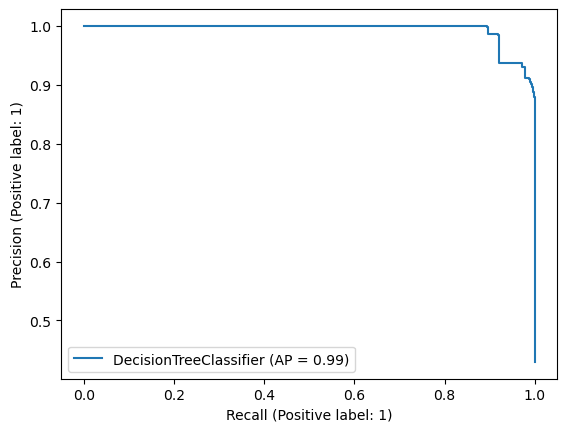

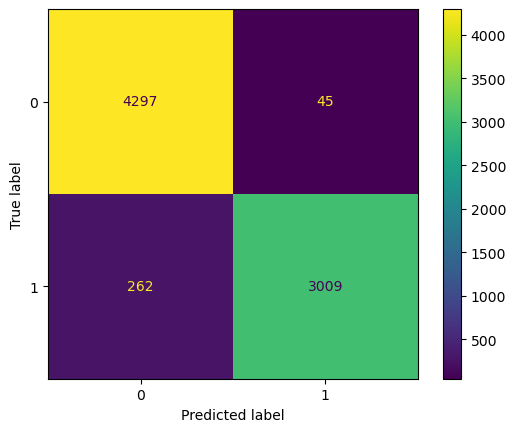

In [16]:
model_slct = tree_model

PrecisionRecallDisplay.from_estimator(model_slct, X_pca, y_train)
ConfusionMatrixDisplay.from_estimator(model_slct, X_pca, y_train)
pd.DataFrame(precision_recall_fscore_support(y_train, model_slct.predict(X_pca)), index= ['precision','recall','f1score','support']).head(3)

In [17]:
print("LogReg:")
print(cross_val_score(logreg_model, X_pca, y_train, cv= 5))
print('-----------------------------------------------------')

print("KNN:")
print(cross_val_score(knn_model, X_pca, y_train, cv= 5))
print('-----------------------------------------------------')

print("Tree Model:")
print(cross_val_score(tree_model, X_pca, y_train, cv= 5))

LogReg:
[0.667761   0.64149705 0.64346684 0.6911958  0.73390276]
-----------------------------------------------------
KNN:
[0.65068943 0.58108995 0.60801051 0.6130092  0.6629435 ]
-----------------------------------------------------
Tree Model:
[0.55219961 0.56401838 0.56598818 0.59592641 0.62089356]


In [29]:
res_cv = pd.DataFrame(cross_val_score(logreg_model, X_pca, y_train, cv= 5), columns= ['LogReg'])
res_cv['KNN'] = cross_val_score(knn_model, X_pca, y_train, cv= 5)

plt.figure(figsize= (10,5))
plt.plot(re

In [18]:
print(df.loc[719,"text"])

[tree_model.predict(X_pca[719:720,:])[0], logreg_model.predict(X_pca[719:720,:])[0], knn_model.predict(X_pca[719:720,:])[0],
    keyword_lreg.predict(X_keyword[719:720,:])[0]]

you can stab me in the back but I promise you'll be the one bleeding


[1, 0, 0, 0]

,keyword,text,target,tree_predict,logreg_predict,keyword_predict,target_predict
7252,weapons,Navy: No charges against officer for weapons v...,1,1,1,0,1
5132,nuclearreactor,If I'm also not mistaken we're sitting right n...,1,1,0,0,0
765,blewup,@iphooey @TIME Ironically Michele Bachmann bro...,0,0,0,0,0
5895,sandstorm,Watch This Airport Get Swallowed Up By A Sands...,1,1,1,1,1
6653,terrorist,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1,1,1,1,1


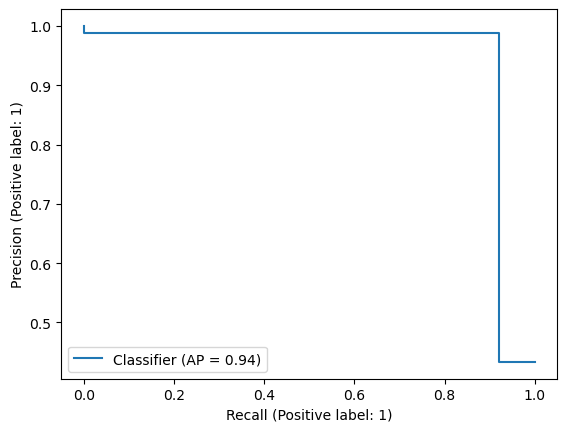

In [19]:
idx_random = random.sample(df.dropna().index.tolist(), 5000)
df_random = df.loc[idx_random, ['keyword','text','target']]

df_random['tree_predict'] = tree_model.predict(X_pca[idx_random, :])
df_random['logreg_predict'] = logreg_model.predict(X_pca[idx_random, :])
df_random['keyword_predict'] = keyword_lreg.predict(count_vec.transform(df.loc[idx_random, 'lemmatized_keyword']))

# overall prediction
df_random['target_predict'] = (df_random[['tree_predict', 'logreg_predict', 'keyword_predict']].sum(axis= 1) >= 2).astype(int)

PrecisionRecallDisplay.from_predictions(df_random.target, df_random.tree_predict)

df_random.head()

In [20]:
## check a new random tweet
df_test = pd.read_csv("data/test.csv")
df_test['lemmatized_keyword'] = df_test['keyword'].apply(lambda x: lemmatize(x.replace('%20','')) if isinstance(x,str) else x)
test_tweets = df_test['text'].tolist()

test_tweets = [lemmatize(clean_tweet(tt)) for tt in test_tweets]
X_test = svd.transform(vectorizer.transform(test_tweets))

df_test['tree_predict'] = tree_model.predict(X_test)
df_test['logreg_predict'] = logreg_model.predict(X_test)
df_test['knn_predict'] = knn_model.predict(X_test)

# only non NA keywords
non_na_idx = df_test.dropna(subset= ['lemmatized_keyword']).index.tolist()
df_test.loc[non_na_idx, "keyword_predict"] = keyword_lreg.predict(count_vec.transform(df_test.loc[non_na_idx, 'lemmatized_keyword']))

# Overall Predict
df_test['target'] = np.nan
# if tree and logreg prediction the same
df_test.loc[df_test.tree_predict == df_test.logreg_predict, "target"] = df_test.loc[df_test.tree_predict == df_test.logreg_predict, "tree_predict"]
# if not the same consider the max
tmp_idx = df_test.loc[(~df_test.keyword.isna()) & df_test.target.isna()].index
df_test.loc[tmp_idx, "target"] = (df_test.loc[tmp_idx,["logreg_predict", "keyword_predict", "knn_predict"]].sum(axis= 1) > 2).astype(int)
# remaining
df_test.loc[df_test.target.isna(), "target"] = (df_test.loc[df_test.target.isna(),["logreg_predict", "knn_predict"] 
                    ].mul([0.7, 0.3]).sum(axis= 1) >= 0.5).astype(int)


# convert to int
df_test['target'] = df_test['target'].astype(int)

print(df_test.loc[random.sample(df_test.index.tolist(),20)])


         id         keyword                       location  \
1726   5823            hail                     Ontario CA   
1874   6308         hostage                            NaN   
1886   6357        hostages                          China   
1263   4155           drown    land-where-everything-sucks   
328    1063        bleeding                            NaN   
1307   4302    dust%20storm   Playing: HL2: EP1, Dust: AET   
2874   9521       terrorist                            NaN   
3048  10095         typhoon                            NaN   
1685   5697          floods            Manila, Philippines   
2686   8951           storm                            NaN   
1893   6378        hostages                Rocky Mountains   
608    1984    bush%20fires                     SQU\/D, uk   
298     970           blaze        Lithgow, NSW, Australia   
2807   9331         survive                            NaN   
990    3269        demolish                 Abuja, Nigeria   
2030   6

In [21]:
df_submission = df_test[['id', "target"]]
df_submission.to_csv("data/submission_combined_weighted_models.csv", index= False)

df_test[['id', "tree_predict"]].rename(columns = {'tree_predict':'target'}).to_csv("data/submission_new_tree.csv", index= False)

df_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [22]:
for ii in df_test.tail(60).head(30).index.tolist():
    print("Target: " + str(df_test.loc[ii,'target']))
    print(df_test.loc[ii,"text"])
    print(test_tweets[ii])
    print(df_test.loc[ii, ['tree_predict','logreg_predict','knn_predict','keyword_predict']])
    print("Keyword: " + str(df_test.loc[ii,"lemmatized_keyword"]))
    print("-----------------------------------------------------------------")

Target: 0
'@GoogleFacts: Wounds heal faster if you lick them. Tears also help them heal as well.'  I know right even thou it seems stupid when lickin
googlefact wound heal faster if you lick them tear also help them heal a well i know right even thou it seem stupid when lickin
tree_predict         1
logreg_predict       0
knn_predict          0
keyword_predict    1.0
Name: 3203, dtype: object
Keyword: wound
-----------------------------------------------------------------
Target: 0
the wounds of honor
 are self-inflicted
the wound of honor be selfinflict
tree_predict         1
logreg_predict       0
knn_predict          0
keyword_predict    1.0
Name: 3204, dtype: object
Keyword: wound
-----------------------------------------------------------------
Target: 1
ME: gun shot wounds 3 4 6 7 'rapidly lethal' would have killed in 30-60 seconds or few minutes max. #kerricktrial
me gun shoot wound rapidly lethal would have kill in second or few minute max kerricktrial
tree_predict         1
lo